# Cas9 Variants Off-Target Analysis

The purpose of this notebook is to analyze the off-target profiles of ecas9-1.1, HiFi-Cas9 and WTCas9 that were screened with the off-target library of single and double mismatches. This code is used to generate Figure 2 (b-e) and Supplementary Figure 3a,b. 

In [1]:
import pandas as pd
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import roc_curve, auc

In [2]:
lfc_df = pd.read_table('../data_files/Fig 2_HF off-targets/processed/HF_off-target_CP1520_avglfc_v2.txt', index_col=0)
#This was obtained from Doench et al. 2016
wt_cas9_cfd = pd.read_csv('../data_files/Fig 2_HF off-targets/external/cfd_2016.csv')
#This file is provided in Supplementary Data 2
lib_meta = pd.read_excel('../data_files/Fig 2_HF off-targets/raw/Supplementary_Data2_v5.xlsx', sheet_name='Library annotation')

In [3]:
len(lib_meta)

34537

Merge lfcs with meta file 

In [4]:
lfc_df = pd.merge(lfc_df, lib_meta, left_on = 'sgRNA sequence', right_on='Mismatch Sequence', how='inner')

There are some mismatched guides with 4 T's or a BsmBI site that made it through our filteirng scheme in the library design

In [5]:
lfc_df[['Duplicate', '4Ts', 'BsmBI site']].value_counts()

Duplicate  4Ts  BsmBI site
n          n    n             31681
           y    n               173
dtype: int64

We'll filter out guides that either have a 4T or BsmBI site

In [6]:
filtered_lfcs = lfc_df[(lfc_df['4Ts'] != 'y') &
                       (lfc_df['BsmBI site'] != 'y')]
print('Filtered ' + str(lfc_df.shape[0] - filtered_lfcs.shape[0]) + ' bad guides')

Filtered 173 bad guides


## Calculating the probability that each guide is active
We use the 21 perfect match guides as true positives and the 1000 control guides as true negatives to fit a logistic regression for each condition and predict whether each guide is a perfect match or control based on its log-fold change. We use the fit model to map from log-fold changes to the probability of being active (i.e. being a perfect match sgRNA). A value near 1 indicates a guide is active and a value near 0 indicates a guide is inactive.

In [7]:
long_lfcs = (filtered_lfcs.melt(id_vars=['sgRNA sequence', 'ConstructID',
                                         'WT Sequence', 'Mismatch Sequence',
                                         'PAM', 'g20', 'G20', 'Number of mismatches',
                                         'Type of Mismatch', 'Mismatch Position'],
                                value_vars=['WT-Cas9_AVGLFC_frompDNA',
                                            'eCas9-1.1_AVGLFC_frompDNA',
                                            'HiFi Cas9_AVGLFC_frompDNA'],
                                var_name='condition', value_name='lfc')
             .rename({'Construct IDs': 'Target ID'}, axis=1))
long_lfcs['condition'] = long_lfcs['condition'].replace({'WT-Cas9_AVGLFC_frompDNA': 'WTCas9',
                                                         'eCas9-1.1_AVGLFC_frompDNA': 'eCas9',
                                                         'HiFi Cas9_AVGLFC_frompDNA': 'HiFi-Cas9'})
long_lfcs['Number of mismatches'] = pd.Categorical(long_lfcs['Number of mismatches'], 
                                                   categories=['none', 'single', 'double', 'Control'])

In [8]:
def build_logistic_model(data, activity_col, category_col, active_category):
    model = LogisticRegression(random_state=7)
    X = data[[activity_col]]
    y = data[category_col] == active_category
    model.fit(X, y)
    return model

def get_probability_active(data, activity_col, category_col, active_category, inactive_category):
    model_matrix = data[data[category_col].isin([active_category, inactive_category])]
    model = build_logistic_model(model_matrix, activity_col, category_col, active_category)
    data['active_probability'] = model.predict_proba(data[[activity_col]])[:,1] # 1 == active
    return data
    
active_probability_df = long_lfcs.groupby('condition').apply(lambda df: get_probability_active(df, 'lfc', 'Number of mismatches', 
                                                                       'none', 'Control'))

Ridge plots that are shown in Figure 2b

In [9]:
long_lfcs['Number of mismatches'] = long_lfcs['Number of mismatches'].replace({'none' : 'Perfect Match',
                                                                              'single' : 'Single',
                                                                              'double': 'Double',
                                                                              'Control': 'Non-targeting Control'})

In [10]:
color_dictionary = dict({'Non-targeting Control':'#8da0cb',
                  'Double':'#fc8d62',
                  'Single': '#66c2a5',
                  'Perfect Match': '#e78ac3'})

In [11]:
wt_long = long_lfcs[long_lfcs['condition'] == 'WTCas9']

Text(0.5, 0.98, 'WTCas9')

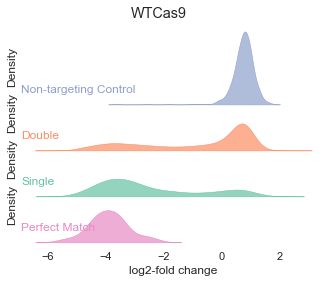

In [12]:
#WT
g = gpplot.ridgeplot(wt_long, 'lfc','Number of mismatches', palette=color_dictionary,
                     row_order = ['Non-targeting Control', 'Double', 'Single', 'Perfect Match'])
g.fig.subplots_adjust(hspace=-.4)
plt.xlabel('log2-fold change')
plt.suptitle('WTCas9')

In [13]:
ecas9_long = long_lfcs[long_lfcs['condition'] == 'eCas9']

Text(0.5, 0.98, 'eCas9')

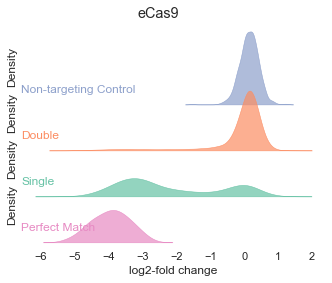

In [14]:
#eCas9
g = gpplot.ridgeplot(ecas9_long, 'lfc','Number of mismatches', palette=color_dictionary,
                     row_order = ['Non-targeting Control', 'Double', 'Single', 'Perfect Match'])
g.fig.subplots_adjust(hspace=-.4)
plt.xlabel('log2-fold change')
plt.suptitle('eCas9')
#plt.savefig('../../Figures/panels/Fig 2/eCas9_ridge.pdf', bbox_inches ='tight', dpi = 1000, transparent='True')

In [15]:
hifi_long = long_lfcs[long_lfcs['condition'] == 'HiFi-Cas9']

Text(0.5, 0.98, 'HiFi-Cas9')

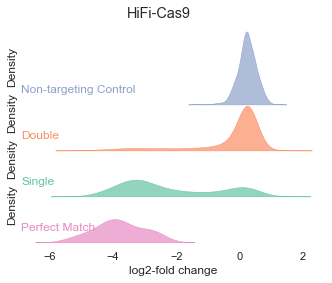

In [16]:
#HiFi
g = gpplot.ridgeplot(hifi_long, 'lfc','Number of mismatches', palette=color_dictionary,
                     row_order = ['Non-targeting Control', 'Double', 'Single', 'Perfect Match'])
g.fig.subplots_adjust(hspace=-.4)
plt.xlabel('log2-fold change')
plt.suptitle('HiFi-Cas9')

## Comparing across enzymes

We compare the averaged probabilities for each mismatch type and position between the Cas9 variants and see good correspondce. The high fidelity variants generally show less promiscuity at the PAM distal end of guides with eCas9 showing the least promiscuity. This is shown in Supplementary Figure 3b.

In [17]:
single_mismatch_active_probability = (active_probability_df[active_probability_df['Number of mismatches'] == 'single']
                                      .groupby(['Type of Mismatch', 'Mismatch Position', 'condition'])
                                      .agg(avg_active_prob_single = ('active_probability', 'mean'))
                                      .reset_index())
single_mismatch_active_probability['Mismatch Position'] = single_mismatch_active_probability['Mismatch Position'].astype(int)
spread_single_mismatch = (single_mismatch_active_probability.pivot_table(values='avg_active_prob_single', 
                                                                         index=['Type of Mismatch', 'Mismatch Position'], 
                                                                         columns=['condition'])
                          .reset_index())
spread_single_mismatch['Mismatch Position'] = spread_single_mismatch['Mismatch Position'].astype('int')

rG:dT mismatches are promiscuous across variant types

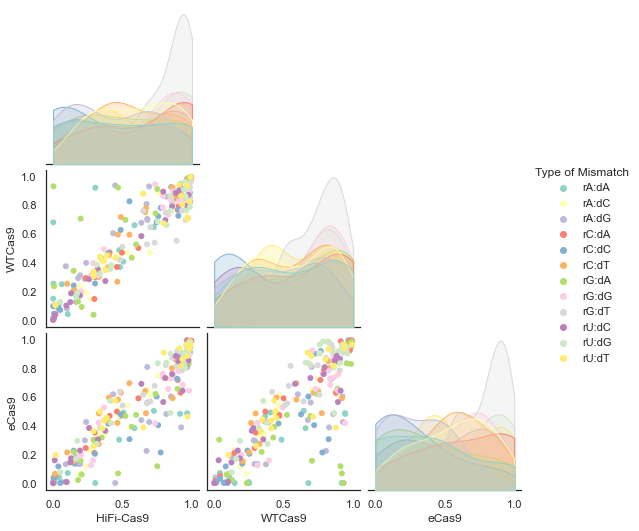

In [18]:
g = sns.pairplot(spread_single_mismatch.drop('Mismatch Position', axis=1), hue='Type of Mismatch',  
                 corner=True, palette='Set3', aspect=1, diag_kind='kde',
                 plot_kws=dict(linewidth=0),
                 diag_kws={'clip': (0.0, 1.0)})

When we compare against the activity values for wtCas9 in the 2016 RS2 paper we see a middling correlation of 0.61. This is shown in Supplementary Figure 3a.

Text(0, 0.5, 'RS2 (2016)')

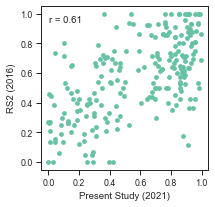

In [19]:
gpplot.set_aesthetics(context='paper', palette='Set2')
merged_cfds = spread_single_mismatch.merge(wt_cas9_cfd.rename({'Mismatch Type': 'Type of Mismatch',
                                                 'Position': 'Mismatch Position'}, axis=1), how='inner', 
                             on=['Type of Mismatch', 'Mismatch Position'])
fig, ax = plt.subplots(figsize=(3,3))
sns.scatterplot(data=merged_cfds, x='WTCas9', y='Percent-Active', ax=ax, linewidth=0)
gpplot.add_correlation(data=merged_cfds, x='WTCas9', y='Percent-Active')
plt.xlabel('Present Study (2021)')
plt.ylabel('RS2 (2016)')

## Predicting Double Mismatch Activity

To predict the double mismatches, we will multiply the average probability of each single mismatch together. Using the same logistic regression models as before we define any double mismatch guide with a > 50% probability of being a perfect match based on its log-fold change as active. Using this cutoff to define true positives and ranking by the multiplied single mismatch probabilities, we can see that we can predict the activity of the double mismatch guides fairly well. 

The following code is used to make Figure 2e.

In [20]:
double_mismatch_df = active_probability_df[active_probability_df['Number of mismatches'] == 'double'].copy()
double_mismatch_df[['Type of Mismatch 1', 'Type of Mismatch 2']] = double_mismatch_df['Type of Mismatch'].str.split(',', expand=True)
double_mismatch_df[['Mismatch Position 1', 'Mismatch Position 2']] = double_mismatch_df['Mismatch Position'].str.split(',', expand=True)
double_mismatch_df[['Mismatch Position 1', 'Mismatch Position 2']] = double_mismatch_df[['Mismatch Position 1', 'Mismatch Position 2']].astype(int)

double_mismatch_df = double_mismatch_df.merge(single_mismatch_active_probability
                                              .rename({'Type of Mismatch': 'Type of Mismatch 1',
                                                       'Mismatch Position': 'Mismatch Position 1'}, axis=1), how='inner', 
                                              on = ['Type of Mismatch 1', 'Mismatch Position 1', 'condition'])
double_mismatch_df = double_mismatch_df.merge(single_mismatch_active_probability
                                              .rename({'Type of Mismatch': 'Type of Mismatch 2',
                                                       'Mismatch Position': 'Mismatch Position 2'}, axis=1), how='inner', 
                                              on = ['Type of Mismatch 2', 'Mismatch Position 2', 'condition'], 
                                              suffixes = [' 1', ' 2'])
double_mismatch_df['predicted_activity'] = double_mismatch_df['avg_active_prob_single 1'] * double_mismatch_df['avg_active_prob_single 2']
double_mismatch_df['active'] = double_mismatch_df['active_probability'] > 0.5

We see that wtCas9 has the most active double mismatch guides (n=8105), followed by IDT-Cas9 (n=3114) and then eCas9 (n=1592)

In [21]:
(double_mismatch_df.groupby('condition')['active'].value_counts())

condition  active
HiFi-Cas9  False     28566
           True       3115
WTCas9     False     23562
           True       8119
eCas9      False     30088
           True       1593
Name: active, dtype: int64

In [22]:
color_dict = {'HiFi-Cas9' : '#fb9a99',
             'eCas9' : '#b2df8a',
             'WTCas9': '#a6cee3'}

In [23]:
gpplot.set_aesthetics(context='paper')

Text(0.5, 0, 'False Positive Rate \n (Predicted + not observed active)')

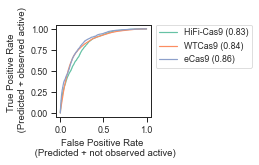

In [24]:
def get_roc_curves(df):
    fpr, tpr, _ = roc_curve(df['active'], df['predicted_activity'])
    roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
    return roc_df

roc_df = (double_mismatch_df
       .groupby('condition')
       .apply(lambda df: get_roc_curves(df))
       .reset_index(level=0))
auc_df = (roc_df
          .groupby('condition')
          .apply(lambda df: auc(df['fpr'], df['tpr']))
       .reset_index(name='auc'))
roc_auc_df = (roc_df.merge(auc_df, how='inner', on='condition'))
roc_auc_df['label'] = roc_auc_df.condition + ' (' + roc_auc_df.auc.round(decimals=2).astype(str) + ')'


fig, ax = plt.subplots(figsize=(1.7,1.7))
sns.lineplot(data=roc_auc_df, x='fpr', y='tpr', hue='label', estimator=None, ax=ax)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('True Positive Rate \n (Predicted + observed active)')
plt.xlabel('False Positive Rate \n (Predicted + not observed active)')

## Heatmaps 

These make up Figure 2d. The CFD matrices were calculated as described in the manuscript and are provided in the Source data file 

In [25]:
cfd = pd.read_csv('../data_files/Fig 2_HF off-targets/processed/cas9_hfvars_cfd_v2.csv')

Use Mismatch Position_x for plots -- this is because in reality, each of these guides screened has the 1st position fixed as a G

In [26]:
wt_cas9 = cfd[cfd['condition'] == 'WTCas9']
wt_cas9 = wt_cas9.pivot('Type of Mismatch', 'Mismatch Position_x', 'prob_active')

In [27]:
gpplot.set_aesthetics(context='notebook')

Text(0.5, 1.0, 'WT-Cas9')

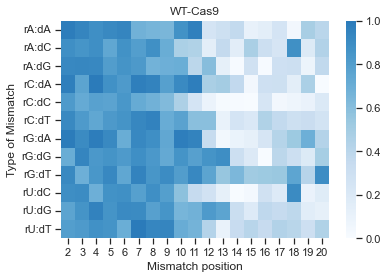

In [28]:
ax = sns.heatmap(wt_cas9, cmap = 'Blues', center = 0.7, vmin=0, vmax=1)
plt.xlabel('Mismatch position')
plt.title('WT-Cas9')

In [29]:
hifi = cfd[cfd['condition'] == 'HiFi-Cas9']
hifi = cfd[cfd['condition'] == 'HiFi-Cas9']
hifi = hifi.pivot('Type of Mismatch', 'Mismatch Position_x', 'prob_active')

In [30]:
gpplot.set_aesthetics(context='notebook')

Text(0.5, 1.0, 'HiFi Cas9')

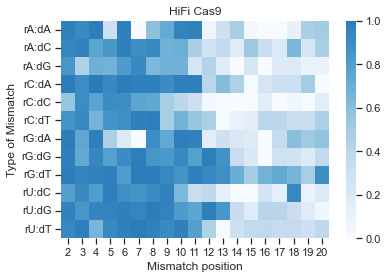

In [31]:
ax = sns.heatmap(hifi, cmap = 'Blues', center = 0.7, vmin=0, vmax=1)
plt.xlabel('Mismatch position')
plt.title('HiFi Cas9')

## Metric for comparing  off-target activity

These values are used to make Figure 2c.


Off-target: perfect match vs single or double

In [32]:
def get_roc_auc(df, col):
    df = df.sort_values(by=col)
    df['true-pos_cumsum'] = np.cumsum(df['ess-val'])
    df['false-pos_cumsum'] = np.cumsum(df['non-ess-val'])
    df['fpr'] = df['false-pos_cumsum']/(df['false-pos_cumsum'].iloc[-1])
    df['tpr'] = df['true-pos_cumsum']/(df['true-pos_cumsum'].iloc[-1])
    df.head()
    roc_auc = auc(df['fpr'],df['tpr'])
    roc_df = pd.DataFrame({'False_Positive_Rate':list(df.fpr), 'True_Positive_Rate':list(df.tpr)})
    return roc_auc, roc_df

## Single mismatches 

In [33]:
perfect_single = filtered_lfcs[(filtered_lfcs['Number of mismatches'] == 'none')
                              |(filtered_lfcs['Number of mismatches'] == 'single')]

In [34]:
perfect_single['ess-val'] = [1 if r['Number of mismatches'] == 'none' else 0 for i,r in perfect_single.iterrows()]
perfect_single['non-ess-val'] = [1 if r['Number of mismatches'] == 'single' else 0 for i,r in perfect_single.iterrows()]

/var/folders/91/6q57rrqj2w96tw7llm9_20rw0000gq/T/ipykernel_82035/2583504116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perfect_single['ess-val'] = [1 if r['Number of mismatches'] == 'none' else 0 for i,r in perfect_single.iterrows()]
/var/folders/91/6q57rrqj2w96tw7llm9_20rw0000gq/T/ipykernel_82035/2583504116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perfect_single['non-ess-val'] = [1 if r['Number of mismatches'] == 'single' else 0 for i,r in perfect_single.iterrows()]


In [35]:
wt_single_auc, wt_single_roc = get_roc_auc(perfect_single, 'WT-Cas9_AVGLFC_frompDNA')
wt_single_auc

0.7609820676375014

In [36]:
ecas_single_auc, ecas_single_roc = get_roc_auc(perfect_single, 'eCas9-1.1_AVGLFC_frompDNA')
ecas_single_auc

0.8829381794840936

In [37]:
hifi_single_auc, hifi_single_roc = get_roc_auc(perfect_single, 'HiFi Cas9_AVGLFC_frompDNA')
hifi_single_auc

0.8194327436113451

## Double mismatches 

In [39]:
perfect_double = filtered_lfcs[(filtered_lfcs['Number of mismatches'] == 'none')
                              |(filtered_lfcs['Number of mismatches'] == 'double')]

In [40]:
perfect_double['ess-val'] = [1 if r['Number of mismatches'] == 'none' else 0 for i,r in perfect_double.iterrows()]
perfect_double['non-ess-val'] = [1 if r['Number of mismatches'] == 'double' else 0 for i,r in perfect_double.iterrows()]

/var/folders/91/6q57rrqj2w96tw7llm9_20rw0000gq/T/ipykernel_82035/759728948.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perfect_double['ess-val'] = [1 if r['Number of mismatches'] == 'none' else 0 for i,r in perfect_double.iterrows()]
/var/folders/91/6q57rrqj2w96tw7llm9_20rw0000gq/T/ipykernel_82035/759728948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perfect_double['non-ess-val'] = [1 if r['Number of mismatches'] == 'double' else 0 for i,r in perfect_double.iterrows()]


In [41]:
wt_double_auc, wt_double_roc = get_roc_auc(perfect_double, 'WT-Cas9_AVGLFC_frompDNA')
wt_double_auc

0.8912402055610918

In [42]:
ecas_double_auc, ecas_double_roc = get_roc_auc(perfect_double, 'eCas9-1.1_AVGLFC_frompDNA')
ecas_double_auc

0.9845423349731927

In [43]:
hifi_double_auc, hifi_double_roc = get_roc_auc(perfect_double, 'HiFi Cas9_AVGLFC_frompDNA')
hifi_double_auc

0.9686367523872653

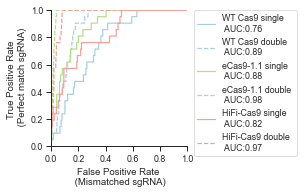

In [44]:
gpplot.set_aesthetics(context='paper')

fig, ax = plt.subplots(figsize=(2.5,2.5))

ax.plot(wt_single_roc.False_Positive_Rate, wt_single_roc.True_Positive_Rate, label='WT Cas9 single\n AUC:0.76', color = '#a6cee3')
ax.plot(wt_double_roc.False_Positive_Rate, wt_double_roc.True_Positive_Rate, label='WT Cas9 double \n AUC:0.89', color = '#a6cee3', linestyle='--')

ax.plot(ecas_single_roc.False_Positive_Rate, ecas_single_roc.True_Positive_Rate, label='eCas9-1.1 single \n AUC:0.88', color ='#b2df8a')
ax.plot(ecas_double_roc.False_Positive_Rate, ecas_double_roc.True_Positive_Rate, label='eCas9-1.1 double \n AUC:0.98', color = '#b2df8a', linestyle='--')

ax.plot(hifi_single_roc.False_Positive_Rate, hifi_single_roc.True_Positive_Rate, label='HiFi-Cas9 single \n AUC:0.82', color ='#fb9a99')
ax.plot(hifi_double_roc.False_Positive_Rate, hifi_double_roc.True_Positive_Rate, label='HiFi-Cas9 double \n AUC:0.97', color = '#fb9a99', linestyle='--')


ax.legend(facecolor='white', loc='lower left')
ax.set_aspect('equal')
plt.xlabel('False Positive Rate \n (Mismatched sgRNA)')
plt.ylabel('True Positive Rate \n (Perfect match sgRNA)')
ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0, 1.0)
plt.xlim(0,1)
sns.despine()